<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cats-Vs-Dogs/Resized%20cats%20vs%20dogs/CvD_15_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [35]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/all-cats-vs-dogs.zip -d cats-vs-dogs

Archive:  /content/drive/My Drive/Gabor Dataset/all-cats-vs-dogs.zip
replace cats-vs-dogs/all/cat.203.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [47]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32

In [48]:
filenames = os.listdir("cats-vs-dogs/all/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [49]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

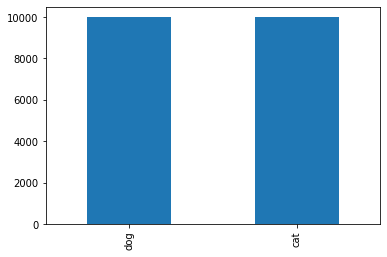

In [50]:
train_df['category'].value_counts().plot.bar()

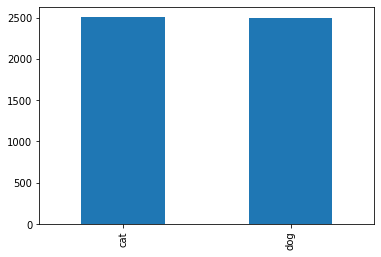

In [51]:
validate_df['category'].value_counts().plot.bar()

In [52]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


In [53]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cats-vs-dogs/all/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [54]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 242, 242, 32)      21632     
_________________________________________________________________
batch_normalization_8 (Batch (None, 242, 242, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
625/625 [==============================] - 71s 113ms/step - loss: 0.7882 - accuracy: 0.6005 - val_loss: 0.6450 - val_accuracy: 0.6214
Epoch 2/1000
625/625 [==============================] - 73s 116ms/step - loss: 0.6116 - accuracy: 0.6757 - val_loss: 0.5731 - val_accuracy: 0.7023
Epoch 3/1000
625/625 [==============================] - 71s 113ms/step - loss: 0.5687 - accuracy: 0.7082 - val_loss: 0.5124 - val_accuracy: 0.7412
Epoch 4/1000
625/625 [==============================] - 70s 112ms/step - loss: 0.5362 - accuracy: 0.7350 - val_loss: 0.5829 - val_accuracy: 0.7141
Epoch 5/1000
625/625 [==============================] - 70s 112ms/step - loss: 0.5088 - accuracy: 0.7521 - val_loss: 0.5599 - val_accuracy: 0.7238
Epoch 6/1000
625/625 [==============================] - 69s 110ms/step - loss: 0.4916 - accuracy: 0.7653 - val_loss: 0.5472 - val_accuracy: 0.7334
Epoch 7/1000
625/625 [==============================] - 69s 111ms/step - loss: 0.4783 - accuracy: 0.7749 - val_loss: 0

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cvd-loss-{}*{}.png'.format(GABOR_WIDTH, GABOR_HEIGHT), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cvd-accuracy-{}*{}.png'.format(GABOR_WIDTH, GABOR_HEIGHT), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cvd-filters-{}*{}.png".format(GABOR_WIDTH, GABOR_HEIGHT), bbox_inches='tight', dpi=350)

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("cvd-channelwise-filters-{}*{}.png".format(GABOR_WIDTH, GABOR_HEIGHT), bbox_inches='tight', dpi=350)